In [37]:
import numpy as np
import sympy as sp
%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.special import erf
import pickle

In [53]:
kappa           = 1e-1      # molecular diffusivity
Bottom          = 0         # bottom of domain
eps             = 1e-1      # "near" wall measure
T               = 5         # final evolution time

nsteps          = int(1e4)
t               = np.linspace(T, 0, nsteps + 1)
tau             = t[0] - t
dt              = t[0] - t[1]
sqrtdt          = abs(dt)**.5
noiseamplitude  = (2*kappa)**.5

def U(x,t):
    return 0

npoints         = 3   #number of base points
nparticles      = 1000   #number of trajectories at each point
x0              = np.zeros(shape = (npoints, nparticles, 1), dtype = np.float32)
x0[:, :, 0]     = np.linspace(0.25, 1, npoints)[:, None]
x               = x0.copy()
LB              = np.zeros(shape = (npoints, nparticles, 1), dtype = np.float32)
HT              = (T+1)**2*np.ones(shape = (npoints, nparticles, 1), dtype = np.float32)



xfull        = np.zeros(shape = (nsteps+1, npoints, nparticles, 1), dtype = np.float32)
localtimeB   = np.zeros(shape = (nsteps+1, npoints, nparticles), dtype = np.float32)
hittingtime  = np.zeros(shape = (npoints, nparticles), dtype = np.float32)
xfull[...,0] = np.linspace(0.25, 1, npoints)[:, None]

In [67]:
print xfull[1,1,2,0]
print xfull[tindex].shape

0.642115
(3, 1000, 1)


In [72]:
for tindex in range(nsteps):
    u = U(xfull[tindex],t[tindex])
    dW = np.random.randn(*xfull.shape[1:])*sqrtdt
    dX = -u*dt + noiseamplitude*dW
    xfull[tindex+1] = xfull[tindex] + dX
    cond1 = xfull[tindex][..., 0] < Bottom + eps
    c1indices = np.where(cond1)
    hittingtime[c1indices] = np.minimum(hittingtime[c1indices], tau[tindex])
    if c1indices[0].size > 0:
        V  = -2*dt*np.log(np.random.random(xfull[tindex].shape))[c1indices]
        Y  = (-dX[c1indices] + np.sqrt(2*kappa*V + dX[c1indices]**2))/2
        dL =  Y - xfull[tindex][c1indices] + Bottom
        dL[np.where(dL < 0)] = 0
        xfull[tindex+1][c1indices]  = xfull[tindex][c1indices]  + dL
    xfull[tindex+1][..., 0] = xfull[tindex+1][..., 0].clip(Bottom)

<IPython.core.display.Javascript object>


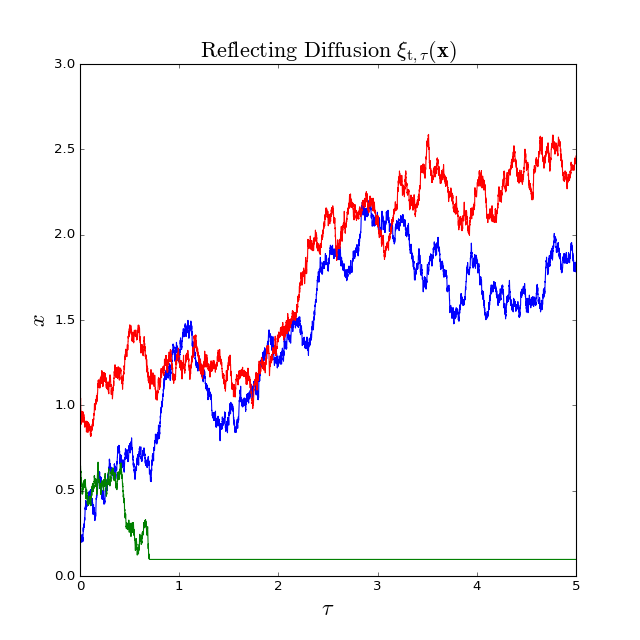

<IPython.core.display.Javascript object>


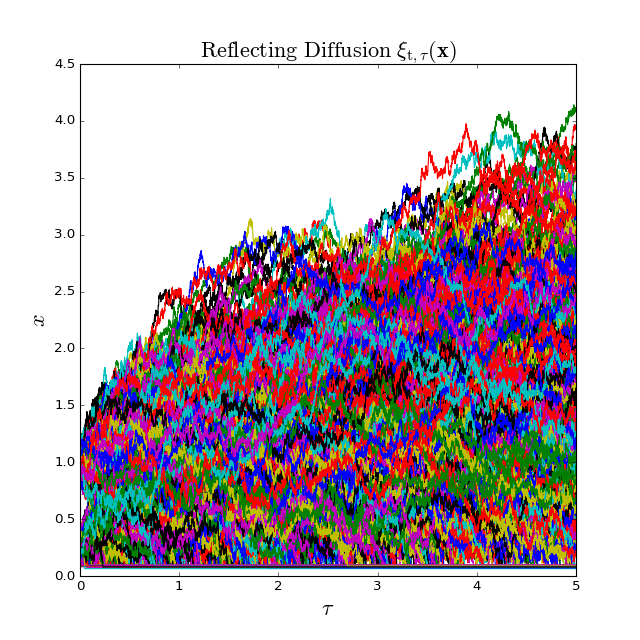

In [75]:
molecular_traj = xfull
particleindx = -1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(npoints):
    ax.plot(tau,molecular_traj[:, i, particleindx, 0])
ax.set_xlim([0,tau[-1]])
ax.set_title('$\\rm Reflecting\ Diffus ion\ {\\xi}_{t,\\tau}(\\mathbf{x})$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$x$', fontsize=20)

space_indx1 = 0
space_indx2 = -1
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(nparticles):
    ax.plot(tau,molecular_traj[:, space_indx1, i, 0])
    ax.plot(tau,molecular_traj[:, space_indx2, i, 0])
ax.set_xlim([0,tau[-1]])
ax.set_title('$\\rm Reflecting\ Diffusion\ {\\xi}_{t,\\tau}(\\mathbf{x})$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$x$', fontsize=20)

In [3]:
for tindex in range(nsteps):
    u = U(x,t[tindex])
    dW = np.random.randn(*x.shape)*sqrtdt
    dX = -u*dt + noiseamplitude*dW
    x += dX
    cond1 = x[..., 0] < Bottom + eps
    c1indices = np.where(cond1)
    HT[c1indices] = np.minimum(HT[c1indices], tau[tindex])
    if c1indices[0].size > 0:
        V  = -2*dt*np.log(np.random.random(x.shape))[c1indices]
        Y  = (-dX[c1indices] + np.sqrt(2*kappa*V + dX[c1indices]**2))/2
        dL =  Y - x[c1indices] + Bottom
        dL[np.where(dL < 0)] = 0
        x[c1indices]  += dL
        LB[c1indices] += dL/kappa
    x[..., 0] = x[..., 0].clip(Bottom)

KeyboardInterrupt: 

In [31]:
#### Record Paramters ###

param = np.array((kappa, Bottom, eps, nsteps, dt, npoints, nparticles), dtype=float)

####### Dump Data #######

#pickle.dump(x,     open( "data_pure_brownian/x_halfLine.p",     "wb" ) )
#pickle.dump(LB,    open( "data_pure_brownian/LB_halfLine.p",    "wb" ) )
#pickle.dump(HT,    open( "data_pure_brownian/HT_halfLine.p",    "wb" ) )
#pickle.dump(param, open( "data_pure_brownian/param_halfLine.p", "wb" ) )


####### Load Data #######

x     = pickle.load( open( "data_pure_brownian/x_halfLine.p",     "rb" ) )
LB    = pickle.load( open( "data_pure_brownian/LB_halfLine.p",    "rb" ) )
HT    = pickle.load( open( "data_pure_brownian/HT_halfLine.p",    "rb" ) )
param = pickle.load( open( "data_pure_brownian/param_halfLine.p", "rb" ) )


#### Set Parameters #####
kappa       = param[0]
Bottom      = param[1]
eps         = param[2]
nsteps      = param[3]
dt          = param[4]
T           = nsteps*dt
npoints     = param[5]
nparticles  = param[6]

In [14]:
print np.min(HT[0,:])
print np.min(HT[1,:])
print np.min(HT[2,:])
print kappa

0.005
0.0546
0.1564
0.1


Use Takac's Eq.(3) as a test on the numerics. For a Brownian motion started at $x_0>0$ at time $t$ and reflected at $x=0$, the PDF $p_{x_0,\tau}(\ell)$ of the local time density at $x=0$ is 

$ p_{x_0,\tau}(\ell)=   \Big(\sqrt{\frac{\kappa}{\pi \tau}} e^{-(x_0+2\kappa \ell)^2/4\kappa \tau}\Big) \Theta(\ell) + \Big(2\Phi_{\kappa,\tau}(x_0)-1\Big) \delta(\ell)$

where $\tau=t-s$, $\Theta(\ell)$ is the Heaviside set-function and $\Phi_{\kappa,t}(x)=\frac{1}{\sqrt{4\pi\kappa t}} \int_{-\infty}^{x} dy\  e^{-y^2/4\kappa t}$ (i.e., the CDF of the normal random variable $N(0,2\kappa t)$).  The CDF is:

$ P_{x_0,\tau}(\ell\leq L)= 2\Phi_{\kappa,\tau}(x_0+ 2\kappa L)-1 =  {\rm erf}\big(\frac{ x_0+ 2\kappa L}{\sqrt{4\kappa \tau}}\big)$

where the error function is defined as ${\rm erf}(x) = \frac{1}{\sqrt{2\pi}}\int_{-x}^x dy\  e^{-y^2}$.  The PDF of the first hitting time is given by

$
p_{x_0}(\tau) = \frac{x_0}{\sqrt{2 \pi \kappa \tau^3}}  e^{-|x_0|^2/2\kappa \tau} 
$

In [34]:
def CDFofNormal(x0,t):
    return 0.5*(1 + erf(x0/np.sqrt(4*kappa*t)))

def localTimeCDF(L,x0,t):
    return  2*CDFofNormal(x0 + 2*kappa*L, t) - 1 

def localTimePDF(ell,x0,t):
    return np.sqrt((4*kappa)/np.pi*t)*np.exp(-(x0 + 2*kappa*ell)**2/(4*kappa*t))

def stoppingTimePDF(tau,x0):
    return x0*np.exp(-x0**2/(4*kappa*tau))/np.sqrt(4*np.pi*kappa*tau**3)

<IPython.core.display.Javascript object>


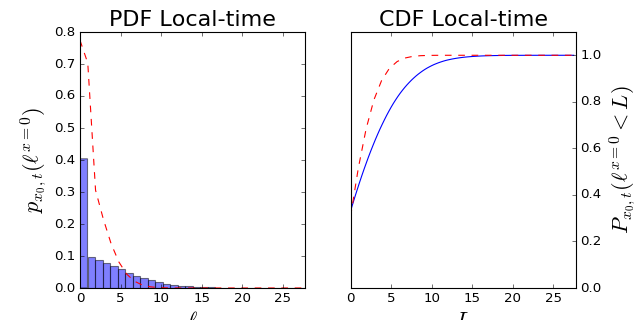

In [35]:
space_index   =  0
dataB         = LB[space_index,:]
MB            = np.max(dataB)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################

bins = np.linspace(0, MB, 30)
weights = np.ones_like(dataB[:,0])/len(dataB[:,0])
ax1.hist(dataB, weights = weights, bins = 30, alpha=0.5)
delta_contribution = np.zeros(bins.shape)
for i in range(bins.shape[0]/15):
    delta_contribution[i] = localTimeCDF(0, x0[space_index, 0, 0], T)
ax1.plot(bins, localTimePDF(bins, x0[space_index, 0, 0], T) + delta_contribution, 'r--')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=0})$', fontsize=20)


values, base = np.histogram(dataB, bins = 100, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])

ax2.plot(base[:-1], cumulative, c='blue')
ax2.plot(bins, localTimeCDF(bins, x0[space_index, 0, 0], T), 'r--')

ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=0}<L)$', fontsize=20)

In [25]:
def stoppingTimePDF(tau,x0):
    return x0*np.exp(-x0**2/(4*kappa*tau))/np.sqrt(4*np.pi*kappa*tau**3)

<IPython.core.display.Javascript object>


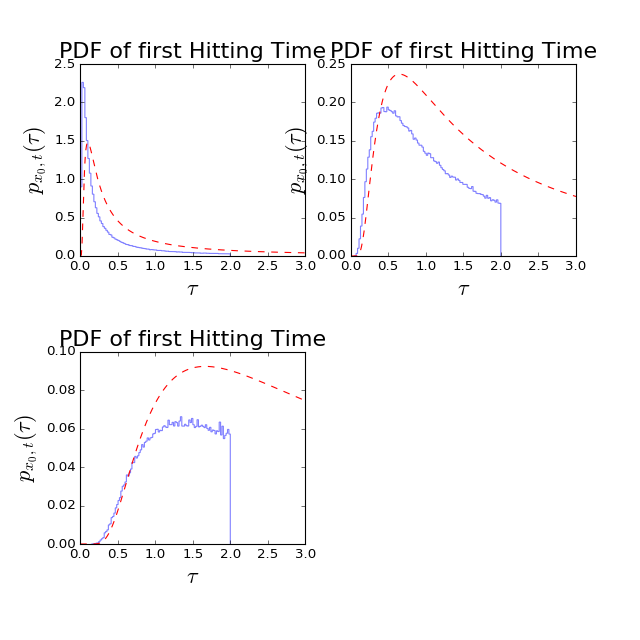

In [11]:
space_index1 = 0
space_index2 = 1
space_index3 = 2

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
fig.subplots_adjust(hspace=.5)

plt.gcf().subplots_adjust(bottom=0.15)

data1 = HT[space_index1, :, np.newaxis]
data1 = data1[data1 < (T+1)**2]
MD1 = np.max(data1)

data2 = HT[space_index2, :, np.newaxis]
data2 = data2[data2 < (T+1)**2]
MD2 = np.max(data2)

data3 = HT[space_index3, :, np.newaxis]
data3 = data3[data3 < (T+1)**2]
MD3 = np.max(data3)

weights1 = np.ones_like(data1[:])/(len(HT[0,:])/30)
weights2 = np.ones_like(data2[:])/(len(HT[1,:])/30)
weights3 = np.ones_like(data3[:])/(len(HT[2,:])/30)

ax1.hist(data1, weights = weights1, bins = 100, alpha=0.5,  histtype = 'step')
taus = np.linspace(0.001, T+1, 350)
theory = stoppingTimePDF(taus, x0[space_index1, 0, 0])
ax1.plot(taus, theory, 'r--')
ax1.set_title('PDF of first Hitting Time', fontsize=20)
ax1.set_xlim([0,T+1])
ax1.set_xlabel('$\\tau$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)

ax2.hist(data2, weights = weights2, bins = 100, alpha=0.5,  histtype = 'step')
taus = np.linspace(0.001, T+1, 350)
theory = stoppingTimePDF(taus, x0[space_index2, 0, 0])
ax2.plot(taus, theory, 'r--')
ax2.set_title('PDF of first Hitting Time', fontsize=20)
ax2.set_xlim([0,T+1])
ax2.set_xlabel('$\\tau$', fontsize=20)
ax2.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)

ax3.hist(data3, weights = weights3, bins = 100, alpha=0.5,  histtype = 'step')
taus = np.linspace(0.001, T+1, 350)
theory = stoppingTimePDF(taus, x0[space_index3, 0, 0])
ax3.plot(taus, theory, 'r--')
ax3.set_title('PDF of first Hitting Time', fontsize=20)
ax3.set_xlim([0,T+1])
ax3.set_xlabel('$\\tau$', fontsize=20)
ax3.set_ylabel('$p_{x_0,t}(\\tau)$', fontsize=20)